In [47]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
from pprint import pprint
import copy


# Load the provided files
stock_file_path = './initial_stock.csv'
classified_products_file_path = './products.csv'

stock_df = pd.read_csv(stock_file_path)
classified_products_df = pd.read_csv(classified_products_file_path)

# Display the structure of the files to ensure we understand their contents
stock_df.head(), classified_products_df.head()

(   product_id  quantity expiry_date  shelf_life  time_in_stock
 0           1        21  2025-02-28          47             13
 1           2        15  2025-05-13         121             20
 2           3        25  2025-05-02         110              8
 3           4        26  2025-06-17         156              0
 4           5        23  2025-08-29         229             16,
          Product_Name        Brand    Category Usage_Frequency  Price_USD  \
 0      Magic Eyeliner     Shiseido    CC Cream          Weekly     149.16   
 1   Perfect Lip Liner  Huda Beauty   Lip Gloss          Weekly      62.28   
 2  Divine Highlighter     Bourjois     Mascara      Occasional      51.65   
 3   Ultra Highlighter     Shiseido      Primer           Daily      71.25   
 4     Ultra Lip Gloss      Kiehl’s  Eye Shadow          Weekly      78.36   
 
    Rating  Number_of_Reviews Product_Size  Skin_Type Gender_Target  \
 0     4.4               6158         50ml  Sensitive        Female   
 1 

In [48]:
# Initialize parameters and data structures
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)
current_date = start_date
warehouse_capacity = 500 # capacidad total del almacén

# Merge stock with product details for easier reference
products = pd.merge(stock_df, classified_products_df, left_on='product_id', right_on='id')

# Create the updated stock dictionary to handle multiple batches per product
initial_stock = {}

for _, row in stock_df.iterrows():
    product_id = row['product_id']
    batch = {
        'quantity': row['quantity'],
        'expiry_date': datetime.strptime(row['expiry_date'], '%Y-%m-%d')
    }
    if product_id not in initial_stock:
        initial_stock[product_id] = []
    initial_stock[product_id].append(batch)

stock = copy.deepcopy(initial_stock)

# Display the updated stock dictionary
#pprint(stock)


sales_data = []  # To store sales records
unsold_products = {}  # To store unsold products and their details

# Helper function for restocking
def restock(stock, initial_stock, current_date):

    print('RESTORIIIIINGGG!!!')

    for product_id, batches in stock.items():
        # Calcular la cantidad inicial requerida sumando los lotes
        initial_quantity = sum(batch['quantity'] for batch in initial_stock.get(product_id, []))
        
        # Calcular la cantidad actual disponible sumando los lotes existentes
        current_quantity = sum(batch['quantity'] for batch in batches)
        
        # Determinar la cantidad faltante para llegar al stock inicial
        missing_quantity = initial_quantity - current_quantity
        
        if missing_quantity > 0:
            # Crear un nuevo batch para reponer el stock faltante
            new_batch = {
                'quantity': missing_quantity,
                'expiry_date': current_date + timedelta(days=random.randint(180,240))
            }
            # Agregar el nuevo batch al stock del producto
            stock[product_id].append(new_batch)

def get_adjustment_factor(current_date):

    # Ajustes por día del mes (principios de mes)
    if current_date.day <= 7:
        day_factor = 1.3
    else:
        day_factor = 1

    # Ajustes por día de la semana (fines de semana)
    if current_date.weekday() in [5, 6]:  # Sábado y domingo
        weekend_factor = 3.0
    else:
        weekend_factor = 1

    if (current_date.year == 2024 and current_date.month >= 6): 

        day_factor = 3

    elif (current_date.year == 2022 and current_date.month == 3):
         day_factor = 3
         
    elif (current_date.year == 2021 and current_date.month <= 4):
         day_factor = 3
        
    # Factor final
    return day_factor * weekend_factor

monthly_demand_factor = {
    1: 1.5,  # Enero
    7: 1.3,  # Julio
    8: 1.3,  # Agosto
    12: 1.5, # Diciembre
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    9: 1,
    10: 1,
    11: 1
}

# Simulate daily sales
while current_date <= end_date:
    month = current_date.month
    
    # Base sales adjusted by month and day factors
    base_sales = random.randint(4,8)
    adjustment_factor = get_adjustment_factor(current_date)
    daily_sales_count = int(base_sales * adjustment_factor) * monthly_demand_factor[month]
    
    daily_sales = []
    total_items_sold = 0

    # Al inicio del día:
    # Verificar productos caducados
    for product_id, batches in stock.items():
        expired_batches = [batch for batch in batches if batch['expiry_date'] <= current_date]
        if expired_batches:
            # Registrar los lotes caducados en `unsold_products`
            if product_id not in unsold_products:
                unsold_products[product_id] = []
            unsold_products[product_id].extend(expired_batches)
            
            # Eliminar los lotes caducados del stock
            stock[product_id] = [batch for batch in batches if batch['expiry_date'] > current_date]

    # Reabastecer si es el primer lunes del mes
    if current_date.weekday() == 0 and (1 <= current_date.day <= 7 or 15 <= current_date.day <= 21):
        restock(stock, initial_stock, current_date)

    if (current_date.year == 2024 and current_date.month >= 6): 

        restock(stock, initial_stock, current_date)

    elif (current_date.year == 2022 and current_date.month == 3):
        restock(stock, initial_stock, current_date)
         
    elif (current_date.year == 2021 and current_date.month <= 4):
        restock(stock, initial_stock, current_date)
    
    
    while total_items_sold < daily_sales_count:
        
        # Extract available products [6,8,28,23,1,14,...]
        available_products = [p for p in stock if any(batch['quantity'] > 0 for batch in stock[p])]
        """ print('Available products: ', available_products) """

    
        # Si no hay productos en el almacén
        if not available_products:
            raise ValueError("ALMACÉN VACÍO!!!!!")
            break
        

        # Clasificar productos según la rotación
        high_rotation = [p for p in available_products if products[products['product_id'] == p].iloc[0]['Rotation'] == 'High']
        medium_rotation = [p for p in available_products if products[products['product_id'] == p].iloc[0]['Rotation'] == 'Medium']

        # 1. Seleccionar 5 productos de media rotación
        medium_pool = random.sample(medium_rotation, min(5, len(medium_rotation)))

        # 2. Modificar el pool de alta rotación
        high_pool = high_rotation.copy()
        
        # 3. Sumar los pools de alta y media rotación. De la suma total quito 2 y sumo entre 0 y 2.
        final_pool = medium_pool + high_pool

        if len(final_pool) > 2:
            final_pool = random.sample(final_pool, len(final_pool) - 2)  # Quitar 2 productos aleatorios
            duplicates = random.choices(final_pool, k=random.randint(0, 2)) # Seleccionar 2 productos para duplicar
            final_pool.extend(duplicates)  # Duplicar productos seleccionados

        # 3. Combinar ambos pools y mezclarlos
        final_pool = medium_pool + high_pool
        random.shuffle(final_pool)  # Mezclar los productos

        # 4. Procesar ventas en el orden del pool mezclado
        for product_id in final_pool:
            if total_items_sold >= daily_sales_count:
                break

            # Obtener detalles del producto
            product_details = products[products['product_id'] == product_id].iloc[0]

            # Determinar la cantidad a vender (1 o 2 unidades con proporción 90-10)
            sold_quantity = 1 if random.random() < 0.9 else 2

            # Verificar el stock disponible
            batches = sorted(stock[product_id], key=lambda batch: batch['expiry_date'])
            total_stock = sum(b['quantity'] for b in batches)
            sold_quantity = min(sold_quantity, total_stock)

            # Procesar ventas desde los lotes
            remaining_quantity = sold_quantity
            for batch in batches:
                if remaining_quantity <= 0:
                    break
                quantity_to_sell = min(batch['quantity'], remaining_quantity)
                batch['quantity'] -= quantity_to_sell
                remaining_quantity -= quantity_to_sell

            # Registrar la venta
            total_items_in_stock = sum(
                batch['quantity'] for product_batches in stock.values() for batch in product_batches
            )
            sales_data.append({
                'sale_id': len(sales_data) + 1,
                'product_id': product_id,
                'date': current_date,
                'quantity': sold_quantity,
                'total_price': sold_quantity * product_details['Price_USD'],
                'batch_expiry_date': batches[0]['expiry_date'],  # Lote más cercano a caducar
                'remaining_stock': total_stock - sold_quantity,
                'warehouse_occupancy_rate': total_items_in_stock / warehouse_capacity * 100
            })

            total_items_sold += sold_quantity

            # Eliminar lotes vacíos
            batches = [batch for batch in batches if batch['quantity'] > 0]
            stock[product_id] = batches

            # Calcular el total de ítems en el almacén
            print(f"Total de ítems en el almacén: {total_items_in_stock}")


        
    print(f"\nCurrent_date: {current_date}\n")
    #pprint(sales_data)
    # Move to the next day
    current_date += timedelta(days=1)

# Convert sales data to a DataFrame and save
sales_df = pd.DataFrame(sales_data)
sales_file_path = './sales_test.csv'
sales_df.to_csv(sales_file_path, index=False)

Total de ítems en el almacén: 427
Total de ítems en el almacén: 426
Total de ítems en el almacén: 425
Total de ítems en el almacén: 424
Total de ítems en el almacén: 423
Total de ítems en el almacén: 422
Total de ítems en el almacén: 421
Total de ítems en el almacén: 420
Total de ítems en el almacén: 419
Total de ítems en el almacén: 418
Total de ítems en el almacén: 417

Current_date: 2020-01-01 00:00:00

Total de ítems en el almacén: 416
Total de ítems en el almacén: 415
Total de ítems en el almacén: 414
Total de ítems en el almacén: 413
Total de ítems en el almacén: 412
Total de ítems en el almacén: 411
Total de ítems en el almacén: 410
Total de ítems en el almacén: 409
Total de ítems en el almacén: 408
Total de ítems en el almacén: 407
Total de ítems en el almacén: 406

Current_date: 2020-01-02 00:00:00

Total de ítems en el almacén: 405
Total de ítems en el almacén: 404
Total de ítems en el almacén: 403
Total de ítems en el almacén: 402
Total de ítems en el almacén: 401
Total de í

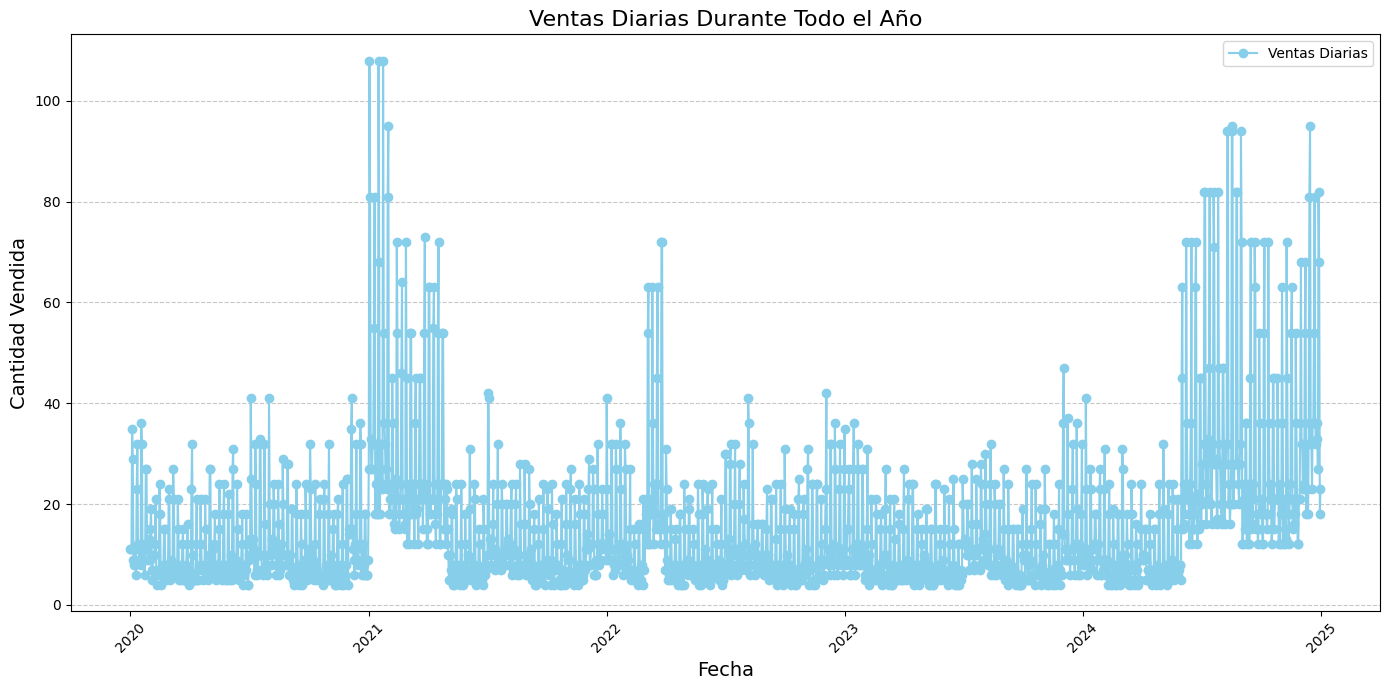

In [49]:
# Re-importing necessary libraries and reloading data since the code environment has been reset
import matplotlib.pyplot as plt
import pandas as pd

# Cargar datos de ventas generados
sales_df = pd.read_csv('./sales_test.csv')

# Convertir la columna 'date' a formato datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Agrupar las ventas por día
daily_sales = sales_df.groupby('date')['quantity'].sum().reset_index()

# Graficar ventas vs días del año
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['date'], daily_sales['quantity'], marker='o', linestyle='-', color='skyblue', label='Ventas Diarias')
plt.title('Ventas Diarias Durante Todo el Año', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


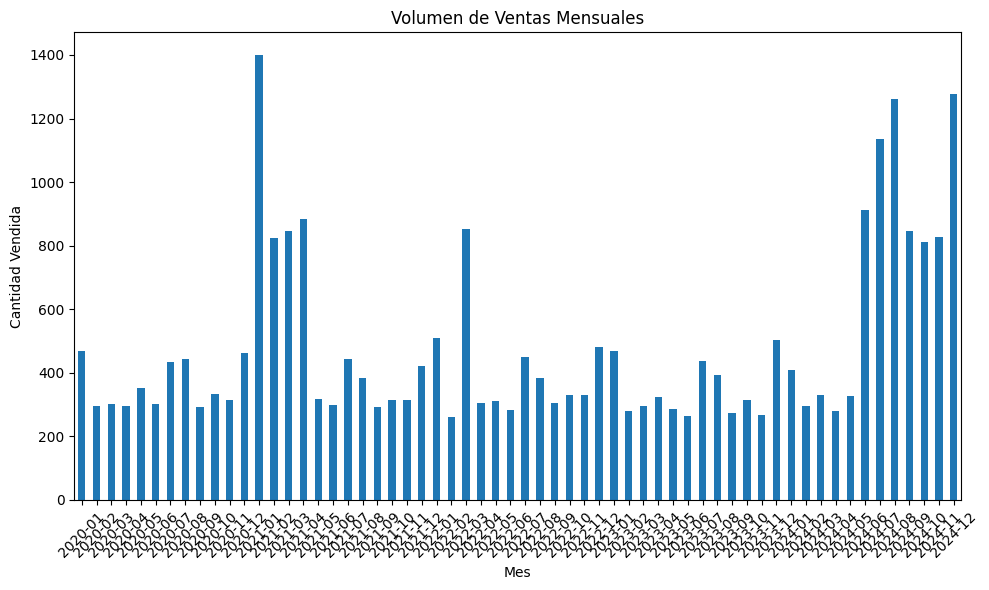

In [50]:
import matplotlib.pyplot as plt

# Asegurarnos de que la columna 'date' sea de tipo datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Calcular las ventas mensuales
monthly_sales = sales_df.groupby(sales_df['date'].dt.to_period('M'))['quantity'].sum()

# Crear la gráfica
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.title('Volumen de Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_13481/3250654184.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_sales['month'] = product_sales['date'].dt.month
/tmp/ipykernel_13481/3250654184.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_sales['day'] = product_sales['date'].dt.day


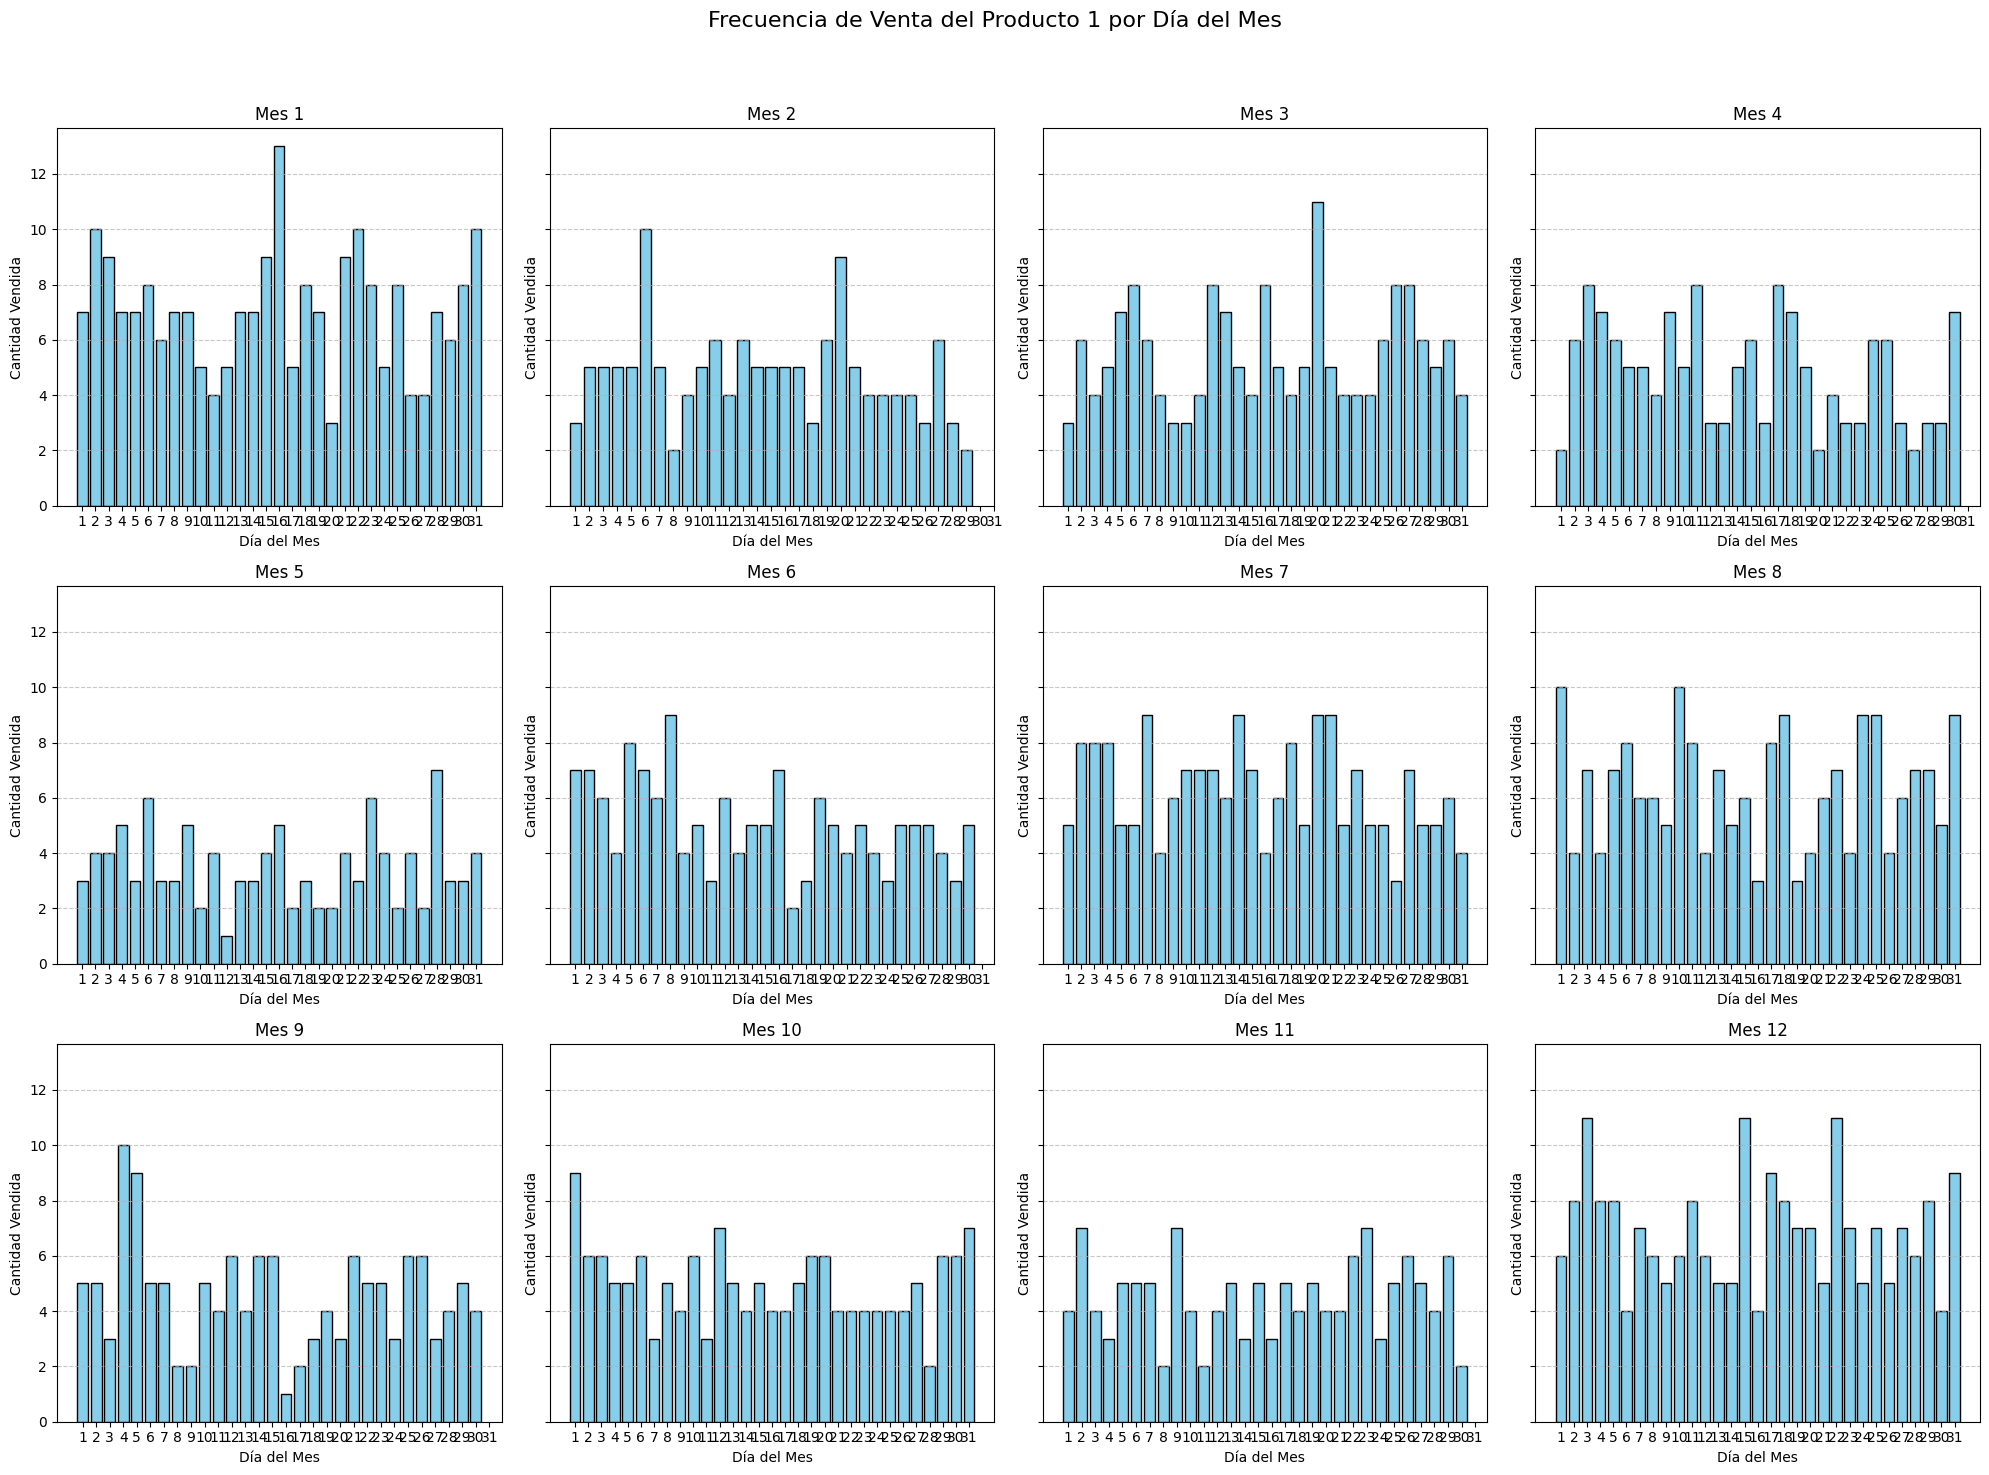

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
sales_data = pd.read_csv('sales_test.csv')
sales_data['date'] = pd.to_datetime(sales_data['date'])  # Convertir la fecha a formato datetime

# Filtrar por un producto específico
product_id_to_analyze = 1  # Cambia este ID al del producto que deseas analizar
product_sales = sales_data[sales_data['product_id'] == product_id_to_analyze]

# Agregar columna de mes y día
product_sales['month'] = product_sales['date'].dt.month
product_sales['day'] = product_sales['date'].dt.day

# Crear una figura con subplots para cada mes
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
fig.suptitle(f'Frecuencia de Venta del Producto {product_id_to_analyze} por Día del Mes', fontsize=16)

# Generar un gráfico para cada mes
for month in range(1, 13):
    ax = axes[(month-1)//4, (month-1)%4]
    month_data = product_sales[product_sales['month'] == month]
    daily_sales = month_data.groupby('day')['quantity'].sum().reset_index()
    
    ax.bar(daily_sales['day'], daily_sales['quantity'], color='skyblue', edgecolor='black')
    ax.set_title(f'Mes {month}')
    ax.set_xlabel('Día del Mes')
    ax.set_ylabel('Cantidad Vendida')
    ax.set_xticks(range(1, 32))  # Mostrar días del 1 al 31
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar el espacio entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


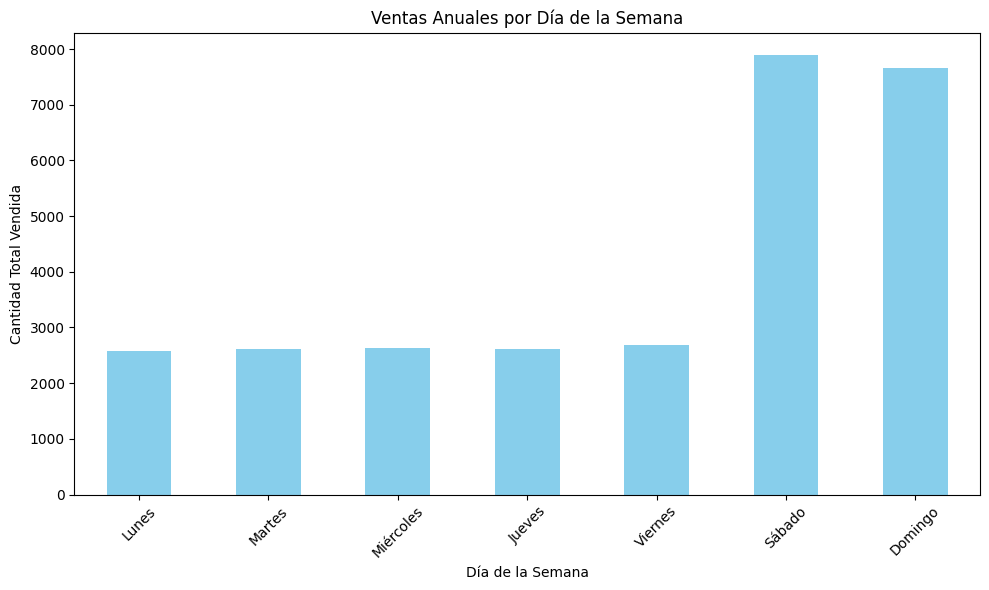

In [52]:
import matplotlib.pyplot as plt
import pandas as pd

# Asegurarte de que la columna 'date' sea de tipo datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])

# Crear una columna con el día de la semana (lunes=0, ..., domingo=6)
sales_df['weekday'] = sales_df['date'].dt.weekday

# Agrupar por día de la semana y sumar las ventas
sales_by_weekday = sales_df.groupby('weekday')['quantity'].sum()

# Cambiar los índices a nombres de los días
sales_by_weekday.index = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Crear el gráfico
plt.figure(figsize=(10, 6))
sales_by_weekday.plot(kind='bar', color='skyblue')
plt.title('Ventas Anuales por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad Total Vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


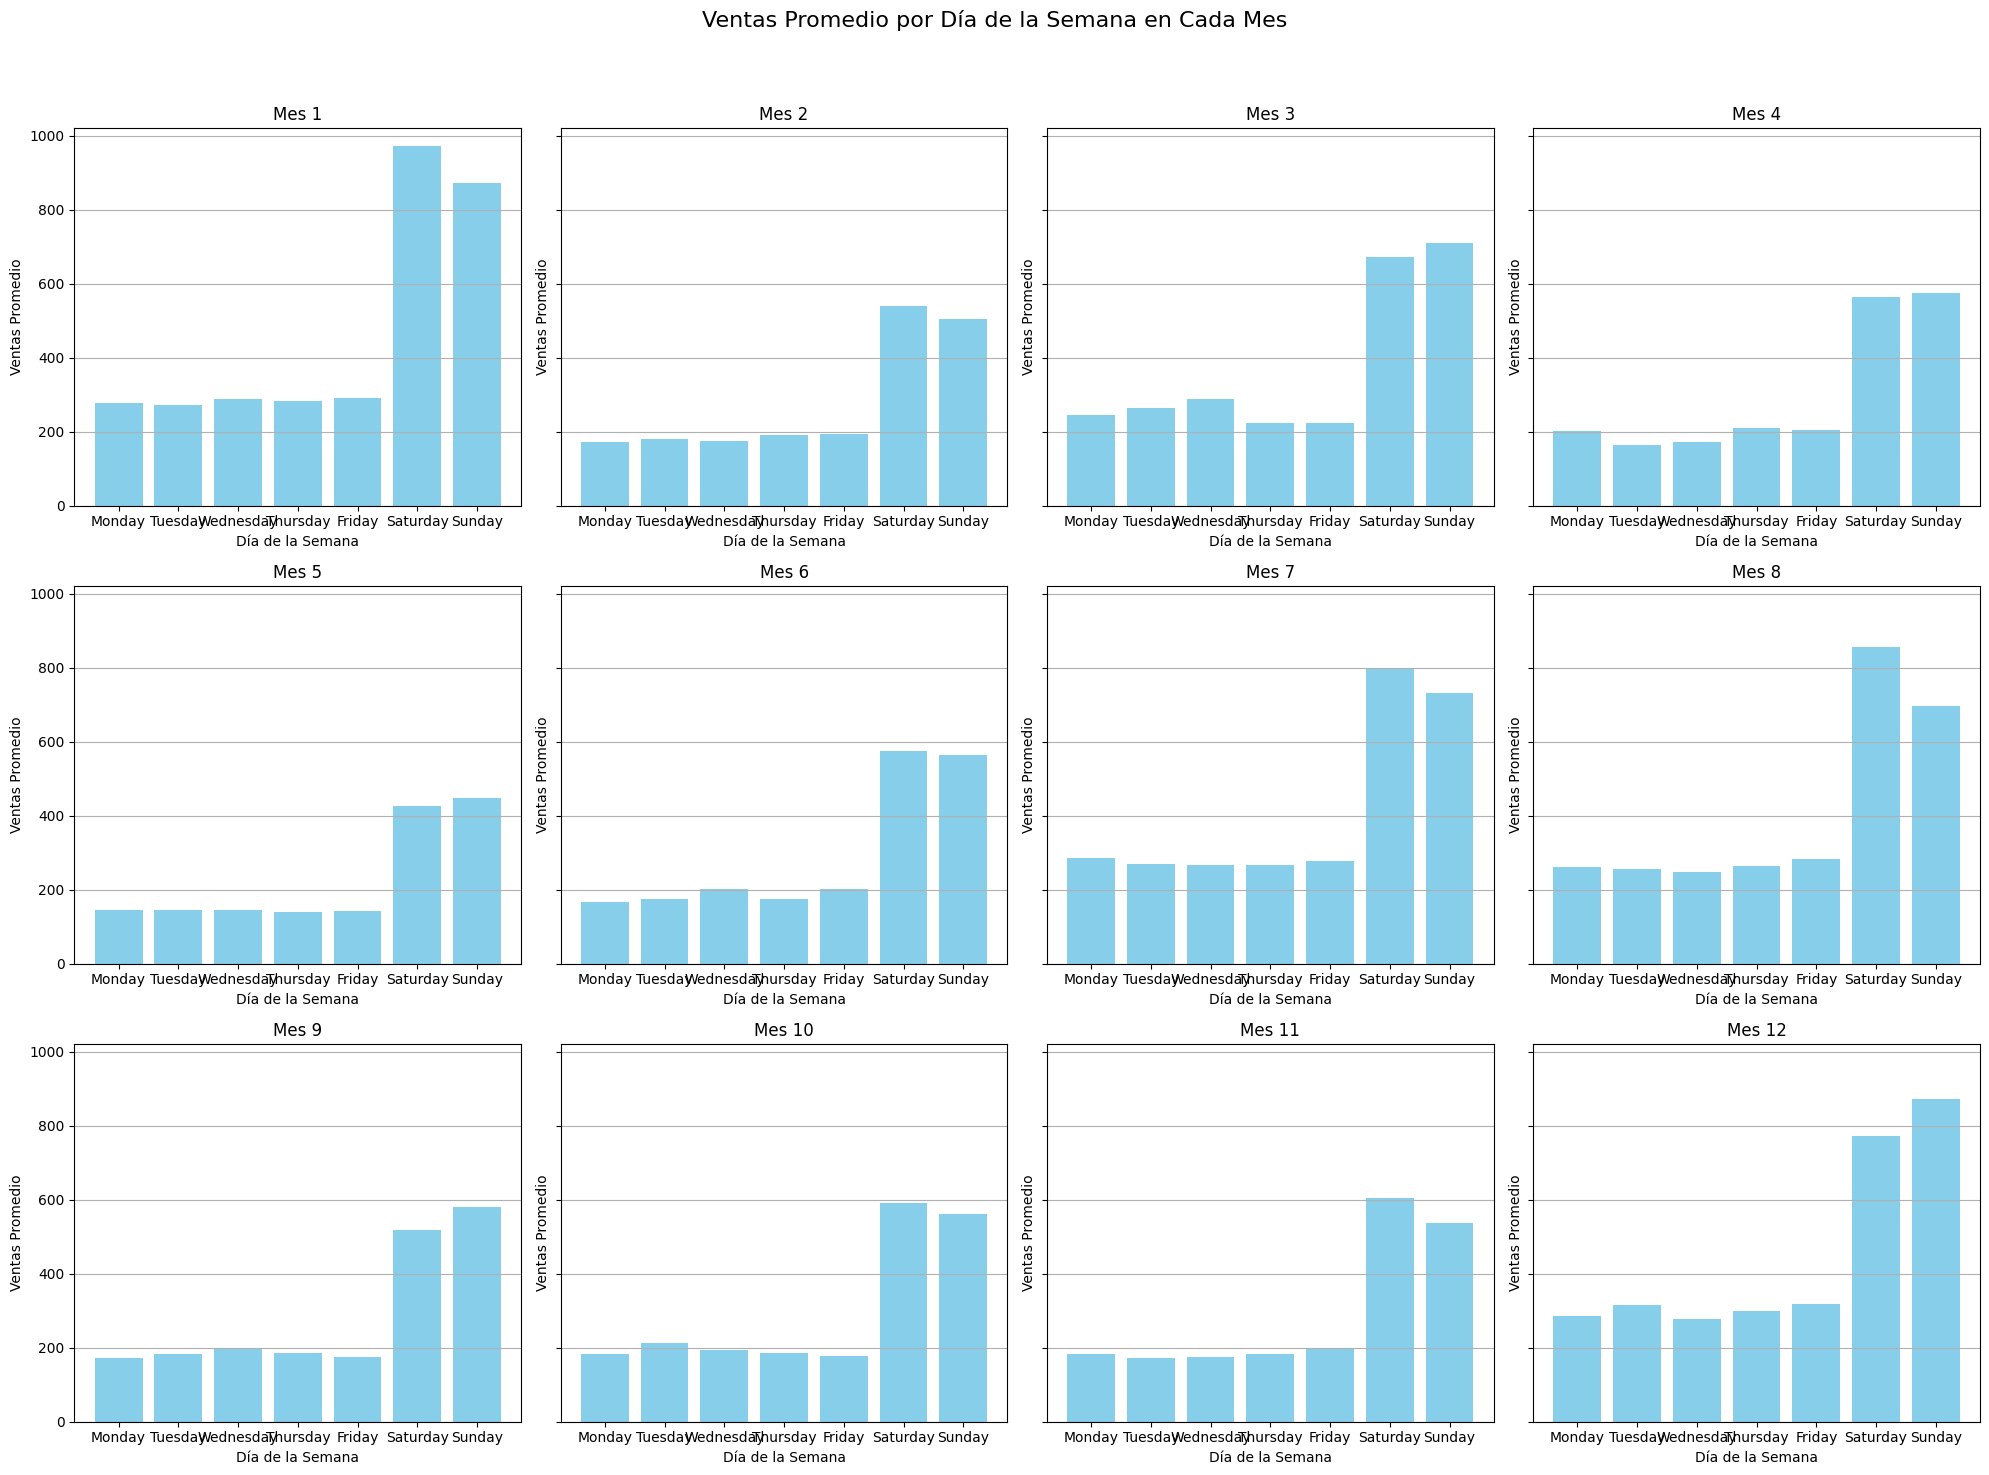

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos
sales_data = pd.read_csv('sales_test.csv')
sales_data['date'] = pd.to_datetime(sales_data['date'])  # Convertir la fecha a formato datetime

# Agregar columnas para mes y día de la semana
sales_data['month'] = sales_data['date'].dt.month
sales_data['day_of_week'] = sales_data['date'].dt.day_name()

# Crear un DataFrame con las ventas promedio por día de la semana para cada mes
monthly_weekday_sales = sales_data.groupby(['month', 'day_of_week'])['quantity'].sum().reset_index()

# Ordenar los días de la semana en el orden correcto
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
monthly_weekday_sales['day_of_week'] = pd.Categorical(
    monthly_weekday_sales['day_of_week'], 
    categories=days_order, 
    ordered=True
)

# Ordenar los datos por mes y día de la semana
monthly_weekday_sales = monthly_weekday_sales.sort_values(['month', 'day_of_week'])

# Crear una figura con subplots para cada mes
fig, axes = plt.subplots(3, 4, figsize=(20, 15), sharey=True)
fig.suptitle('Ventas Promedio por Día de la Semana en Cada Mes', fontsize=16)

# Generar un gráfico para cada mes
for month in range(1, 13):
    ax = axes[(month-1)//4, (month-1)%4]
    month_data = monthly_weekday_sales[monthly_weekday_sales['month'] == month]
    ax.bar(month_data['day_of_week'], month_data['quantity'], color='skyblue')
    ax.set_title(f'Mes {month}')
    ax.set_xlabel('Día de la Semana')
    ax.set_ylabel('Ventas Promedio')
    ax.grid(axis='y')

# Ajustar el espacio entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


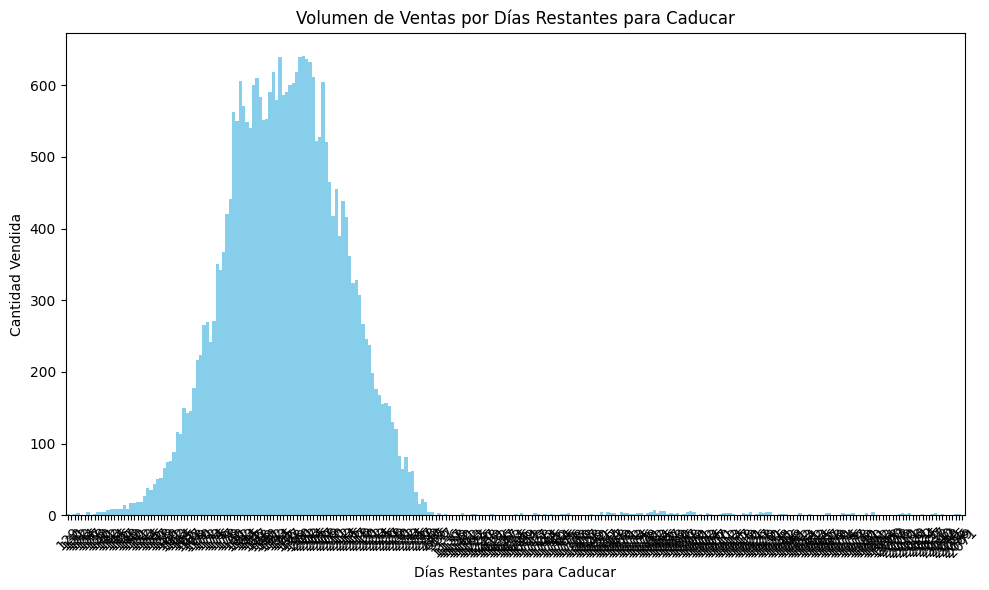

In [54]:
import matplotlib.pyplot as plt

# Asegurarnos de que las columnas de fechas sean de tipo datetime
sales_df['date'] = pd.to_datetime(sales_df['date'])
sales_df['batch_expiry_date'] = pd.to_datetime(sales_df['batch_expiry_date'])

# Calcular los días restantes para la caducidad
sales_df['days_to_expiry'] = (sales_df['batch_expiry_date'] - sales_df['date']).dt.days

# Agrupar por días restantes y sumar las ventas
sales_by_expiry = sales_df.groupby('days_to_expiry')['quantity'].sum()

# Crear el gráfico
plt.figure(figsize=(10, 6))
sales_by_expiry.plot(kind='bar', color='skyblue', width=1)
plt.title('Volumen de Ventas por Días Restantes para Caducar')
plt.xlabel('Días Restantes para Caducar')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
unsold_products_list = [
    {'product_id': product_id, 'quantity': batch['quantity'], 'expiry_date': batch['expiry_date']}
    for product_id, batches in unsold_products.items()
    for batch in batches
]

print(unsold_products_list)


[]
